# Weryfikowanie normalności rozkładu badanej cechy

Poniższy notatnik jest inspirowany wpisami [Jasona Brownlee](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/) oraz [Łukasza Prokulskiego](https://blog.prokulski.science/index.php/2019/01/24/rozklad-normalny-hipotezy-i-regresja-logistyczna/) dotyczącymi testowania rozkładu danych.

Do analiz wykorzystam zbiór danych dotyczących wzrostu i wagi amerykańskich nastolatków [link](https://www.statcrunch.com/app/index.php?dataid=1757964).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

# Get plots with higher resolution
%config InlineBackend.figure_format = 'retina'

# Default styling for plots
sns.set(style="white", palette="muted", color_codes=True)

In [2]:
# Download data if you haven't downloaded yet
if False:
    ! curl "https://www.statcrunch.com/grabdata.php?dataid=1757964&_=1549340655570" > "../data/NLSY97.csv"

In [3]:
# Read data
df = pd.read_csv("../data/NLSY97.csv", delimiter=" ")
df.head(3)

,Gender,Age,Height (inches),Weight (lbs),How would you describe your weight?
0,Female,18,67,150,Slightly overweight
1,Male,17,67,140,About the right weight
2,Female,16,67,100,Slightly underweight


In [4]:
# Convert measurement units
df["Height (cm)"] = df["Height (inches)"] * 2.54     # 1 inch = 2.54cm
df["Weight (kg)"] = df["Weight (lbs)"] * 0.45359237  # 1 pound ~= 0.45kg

In [5]:
# Take only what we are interested in
df = df[["Gender", "Height (cm)", "Weight (kg)"]]
df.head(3)

,Gender,Height (cm),Weight (kg)
0,Female,170.18,68.038855
1,Male,170.18,63.502932
2,Female,170.18,45.359237


In [6]:
male_df   = df[ df["Gender"] == "Male" ]
female_df = df[ df["Gender"] == "Female" ]

In [7]:
male_df.head(3)

,Gender,Height (cm),Weight (kg)
1,Male,170.18,63.502932
4,Male,167.64,65.770894
6,Male,175.26,83.007404


In [8]:
female_df.head(3)

,Gender,Height (cm),Weight (kg)
0,Female,170.18,68.038855
2,Female,170.18,45.359237
3,Female,157.48,83.914588


## Metody graficzne sprawdzenia zgodności z rozkładem

Najszybszym i najprostszym sposobem sprawdzenia, jaki rozkład mają nasze dane, jest wizualizacja graficzna. Takie sprawdzenie jest jakościowe, a więc mniej dokładne od dokładnych formalnych testów statystycznych.

### Histogram

#### Mężczyźni

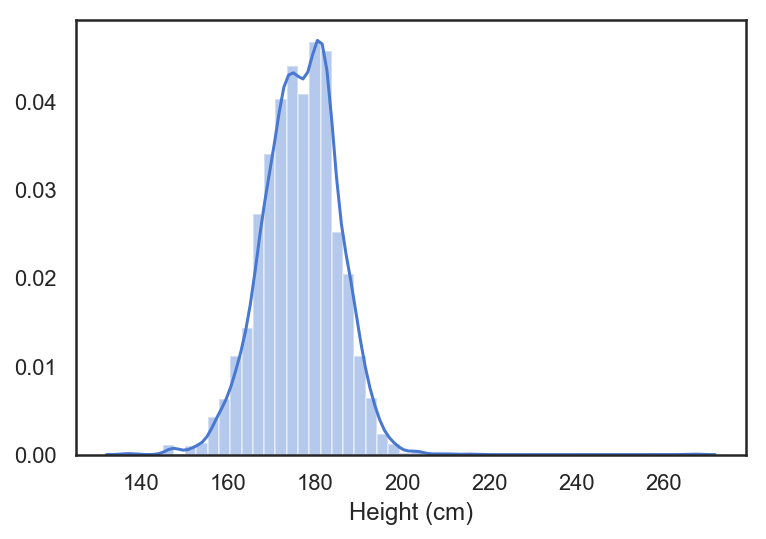

In [9]:
sns.distplot(male_df["Height (cm)"]);

In [10]:
male_df["Height (cm)"].sort_values(ascending=False).head(3)

6533    266.70
5104    215.90
3741    210.82
Name: Height (cm), dtype: float64

Kształt rozkładu empirycznego wzrostu mężczyzn przypomina wykres rozkładu Gaussa, ale niestety wykres nie jest wycentrowany. Wykres ma "długi ogon" po prawej stronie. Jest to spowodowane jedną obserwacją, która odstaje od innych. Biorąc pod uwagę fakt, że [najwyższy człowiek świata](https://pl.wikipedia.org/wiki/Robert_Wadlow) osiągnął wzrost 272 cm, wartość 266.7 cm należy uznać za prawidłową, ekstremalnie odstającą.

#### Kobiety

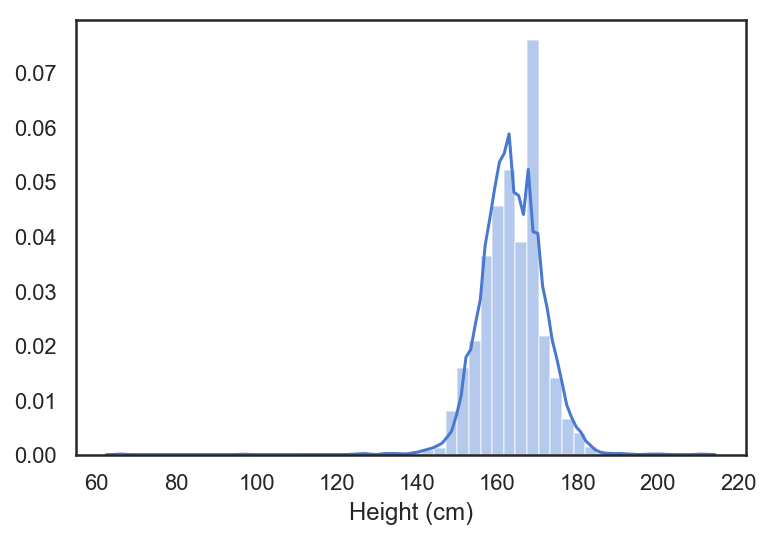

In [11]:
sns.distplot(female_df["Height (cm)"]);

In [12]:
female_df["Height (cm)"].sort_values(ascending=True).head(3)

6607     66.04
7112     96.52
7628    124.46
Name: Height (cm), dtype: float64

Kształt rozkładu empirycznego wzrostu kobiet przypomina wykres rozkładu Gaussa, ale niestety wykres nie jest wycentrowany. Jest to spowodowane dwoma obserwacjami odstającymi z niskimi wartościami wzrostu, przez co wykres ma "długi ogon" po lewej stronie. Najprawdopodobniej w próbie statystycznej znalazły się osoby charakteryzujące się [karłowatością](https://pl.wikipedia.org/wiki/Niedob%C3%B3r_wzrostu).

### Wykres kwantyl-kwantyl

Wykres kwantyl-kwantyl (ang. *quantile-quantile plot* lub **normal probability plot**) metoda, która umożliwia ocenę, które czynniki wpływają na odstępstwo od normalności (czy są to obserwacje ekstremalne, czy rozkład nie jest symetryczny, czy jest on nadmiernie lub niedostatecznie skoncentrowany wokół średniej).

Na wykresie sprawdzamy, czy kwartyle teoretyczne oraz empiryczne układają się na prostej, co wskazałoby, że wartości statystyk porządkowych z próby (kwantyle empiryczne) są proporcjonalne do kwantyli teoretycznych, a to wskazuje, że rozkład zmiennej jest zgodny z założonym rozkładem teoretycznym.

#### Mężczyźni

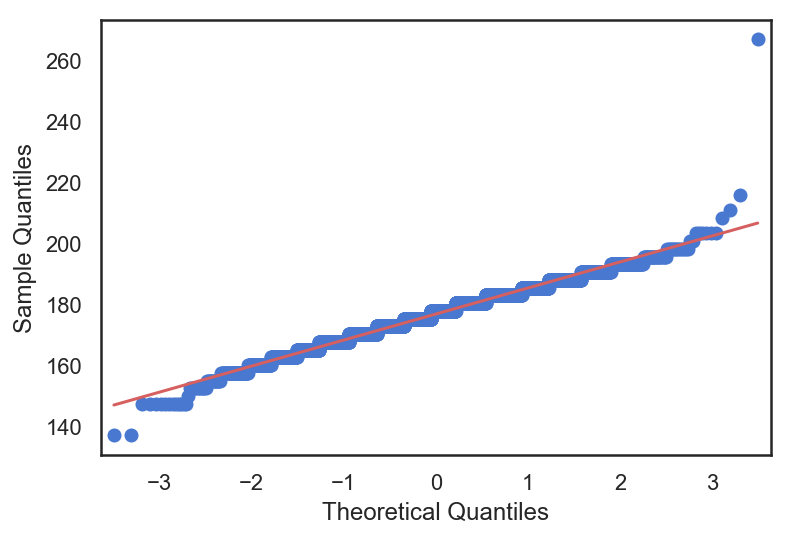

In [13]:
sm.qqplot(male_df["Height (cm)"], line='s');

Dane przedstawione w postaci wykresu punktowego układają się w kształt prostej linii i w dużym stopniu pokrywają się z linią prostą wyznaczoną dla idealnego rozkładu Gaussa. Niemniej zauważyć można pewne odstępstwa dla kilku wartości najmniejszych (które są poniżej prostej) oraz kilku największych (które są powyżej prostej). Oznacza to, że rozkład badanej cechy ma ["długie ogony"](https://www.youtube.com/watch?v=smJBsZ4YQZw&list=PLkIselvEzpM6V9h55s0l9Kzivih9BUWeW) (dłuższe niż w rozkładzie normalnym). Ogon jest szczególnie wydłużony po prawej stronie, bowiem wykres punktowy mocno unosi się do góry.

#### Kobiety

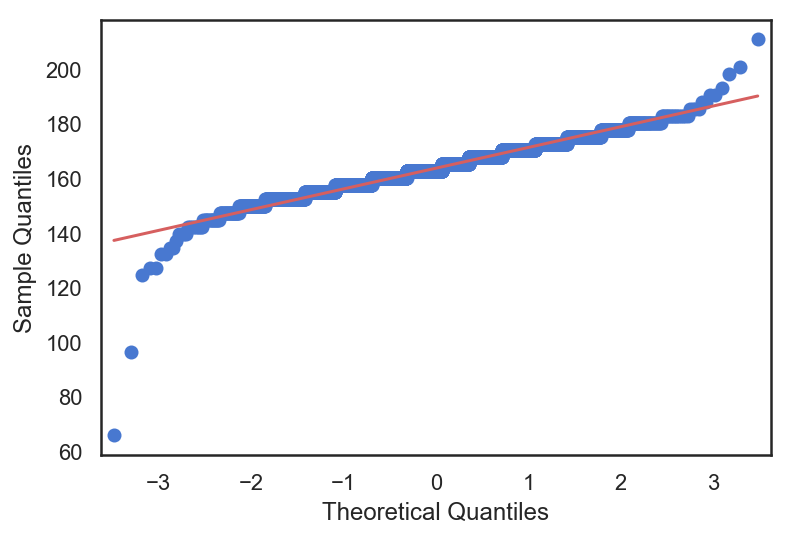

In [14]:
sm.qqplot(female_df["Height (cm)"], line='s');

Dane przedstawione w postaci wykresu punktowego układają się w kształt prostej linii i w dużym stopniu pokrywają się z linią prostą wyznaczoną dla idealnego rozkładu Gaussa. 

Dodatkowo zauważyć można pewne odstępstwa dla kilku wartości najmniejszych (które są poniżej prostej) oraz kilku największych (które są powyżej prostej). Oznacza to, że rozkład badanej cechy ma "długie ogony" (dłuższe niż w rozkładzie normalnym). Ogon jest szczególnie wydłużony po lewej stronie, bowiem wykres punktowy mocno opada w dół.

## Testy statystyczne

Istnieje wiele testów statystycznych, które można użyć do policzenia, czy próba pochodzi z populacji o rozkładzie normalnym. Każdy z testów ma inne założenia oraz analizuje dane pod innym kątem.

W czasie testów hipoteza zerowa i alternatywna mają następującą postać:
* H<sub>0</sub>: Rozkład badanej cechy jest rozkładem normalnym
* H<sub>A</sub>: Rozkład badanej cechy nie jest rozkładem normalnym

### Interpretacja wyników
Każdy z testów zwraca przynajmniej dwa wyniki:
* **wartość statystyki** - wartość empiryczna statystyki testowej wyliczona na podstawie danych podstawionych do konkretnego wzoru (każdy test ma swój osobny wzór statystyki testowej).
* **p-value** - którą używa się do oceny tego, czy dane mają rozkład normalny, czy nie.

Do interpretacji **p-value** potrzebne jest ustalenie **poziomu istotności $\alpha$**, czyli maksymalnego ryzyka błędu, jakie badacz jest skłonny zaakceptować. Zazwyczaj przyjmuje się $\alpha=0.05$; rzadziej 0.03, 0.01.

Wyliczona wartość p-value porównywana jest z poziomem istotności. Interpretacja jest następująca:
* **p-value <= $\alpha$** - odrzucamy H<sub>0</sub>, dane ***nie mają rozkładu normalnego***.
* **p-value > $\alpha$** - brak podstaw do odrzucenia H<sub>0</sub>, dane ***mają rozkład normalny***.

W praktyce zależy nam na otrzymaniu dużych wartości p-value, by potwierdzić, że nasze dane mają rozkład normalny.

### Test Shapiro-Wilka

In [15]:
def shapiro_wilk_test(data, alpha=0.05):
    statistic, pvalue = stats.shapiro(data)
    print("Statistic={:.4f}, p-value={}".format(statistic, pvalue))
    if pvalue > alpha:
        print("Sample looks Gaussian (fail to reject H0)")
        return True
    else:
        print("Sample does not look Gaussian (reject H0)")
        return False

#### Mężczyźni

In [16]:
shapiro_wilk_test(male_df["Height (cm)"]);

Statistic=0.9768, p-value=1.7649029725518982e-25
Sample does not look Gaussian (reject H0)


#### Kobiety

In [17]:
shapiro_wilk_test(female_df["Height (cm)"]);

Statistic=0.9528, p-value=3.6232241712408732e-34
Sample does not look Gaussian (reject H0)


### Test D'Agostino K<sup>2</sup>

In [18]:
def dagostino_k2_test(data, alpha=0.05):
    statistic, pvalue = stats.normaltest(data)
    print("Statistic={:.4f}, p-value={}".format(statistic, pvalue))
    if pvalue > alpha:
        print("Sample looks Gaussian (fail to reject H0)")
        return True
    else:
        print("Sample does not look Gaussian (reject H0)")
        return False

#### Mężczyźni

In [19]:
dagostino_k2_test(male_df["Height (cm)"]);

Statistic=324.8584, p-value=2.8700905055493447e-71
Sample does not look Gaussian (reject H0)


#### Kobiety

In [20]:
dagostino_k2_test(female_df["Height (cm)"]);

Statistic=917.4759, p-value=5.924241743448629e-200
Sample does not look Gaussian (reject H0)


### Test Anderson-Darlinga

Test ten jest modyfikacją testu Kolmogorova-Smirnova (K-S).

In [21]:
def anderson_test(data):
    result = stats.anderson(data)
    print('Statistic: %.3f' % result.statistic)
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

#### Mężczyźni

In [22]:
anderson_test(male_df["Height (cm)"]);

Statistic: 18.945
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.917, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)


#### Kobiety

In [23]:
anderson_test(female_df["Height (cm)"]);

Statistic: 23.853
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.917, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)


TODO: 
* dodać wyjaśnienie, dlaczego testowanie rozkładu jest ważne (z punktu widzenia modeli ML)